In [1]:
import datetime
start_time = datetime.datetime.now()
start_time

datetime.datetime(2022, 4, 25, 3, 30, 42, 397582)

In [2]:
# Also runs installation of dependencies
from lib.util import *

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from sklearn.linear_model import LinearRegression
import statsmodels.stats.api as sms
import math as math
from scipy import stats
import seaborn as sns

In [4]:
import squarify
import altair as alt
import matplotlib
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,leaves_list
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [6]:
df_discharge_2019 = pd.read_stata('../dataset/TEDS-D-2019-DS0001-bndl-data-stata_V1_0.zip', compression='zip')
df_discharge_2019

,DISYR,CASEID,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2019.0,2.019155e+10,2.0,-9.0,4.0,1.0,7.0,-9.0,37.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,1.0
1,2019.0,2.019147e+10,2.0,-9.0,3.0,1.0,7.0,-9.0,35.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,3.0
2,2019.0,2.019144e+10,2.0,-9.0,2.0,1.0,7.0,-9.0,35.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,3.0
3,2019.0,2.019141e+10,2.0,-9.0,3.0,1.0,7.0,-9.0,37.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,3.0
4,2019.0,2.019148e+10,2.0,-9.0,3.0,3.0,7.0,-9.0,37.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722498,2019.0,2.019174e+10,56.0,-9.0,4.0,2.0,7.0,-9.0,33.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,1.0
1722499,2019.0,2.019167e+10,56.0,-9.0,3.0,3.0,7.0,1.0,13.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,2.0
1722500,2019.0,2.019141e+10,56.0,-9.0,2.0,1.0,6.0,-9.0,33.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,2.0
1722501,2019.0,2.019170e+10,56.0,-9.0,1.0,1.0,7.0,3.0,14.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,3.0


In [7]:
cluster_df = df_discharge_2019[['STFIPS', 'REASON']]

In [8]:
dummy_cluster = pd.get_dummies(cluster_df, columns = ['REASON'])
dummy_cluster.columns = ['STFIPS', 'Completed', 'Dropped-out', 'Terminated', 'Transferred', 'Incarcerated', 'Death', 'Other']

In [9]:
seperated_reason_2019D = dummy_cluster.groupby('STFIPS').agg({'Completed':['sum'], 
                                     'Dropped-out':['sum'], 
                                     'Terminated':['sum'], 
                                     'Transferred':['sum'],
                                     'Incarcerated':['sum'],
                                     'Death':['sum'], 
                                     'Other':['sum'], 
                                     'STFIPS':['count']})
seperated_reason_2019D.columns = ['Completed', 'Dropped-out', 'Terminated', 'Transferred', 'Incarcerated', 'Death', 'Other', 'Case_Count']
            

In [10]:
column_inplace = ['Completed', 'Dropped-out', 'Terminated', 'Transferred', 'Incarcerated', 'Death', 'Other']
seperated_reason_2019D.loc[:, column_inplace] = seperated_reason_2019D.loc[:, column_inplace].div(seperated_reason_2019D.Case_Count, axis=0)   
# df.loc[:, cols] = df.loc[:, cols].div(df['A'], axis=0)

In [11]:
seperated_reason_2019D.head()

,Completed,Dropped-out,Terminated,Transferred,Incarcerated,Death,Other,Case_Count
STFIPS,,,,,,,,
1.0,0.339134,0.347795,0.079310,0.131195,0.021010,0.002085,0.079471,12470
2.0,0.383464,0.180599,0.191406,0.119531,0.022135,0.003125,0.099740,7680
4.0,0.993181,0.000540,0.000150,0.000285,0.005050,0.000517,0.000277,133455
5.0,0.592885,0.203557,0.069582,0.123106,0.010128,0.000412,0.000329,12144
6.0,0.231985,0.489734,0.000301,0.262169,0.012457,0.002962,0.000391,133017


In [12]:

scaler = StandardScaler()
scaled_features = scaler.fit_transform(seperated_reason_2019D)
# [column_inplace]

In [13]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
       max_iter=300,
        random_state=42
   )

In [14]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=42)

In [15]:
kmeans.inertia_

302.05027523134993

In [16]:
kmeans.cluster_centers_

array([[ 0.24930688, -0.64877463,  0.48158462, -0.39063316,  0.88097384,
        -0.06150081,  1.03757474, -0.46740645],
       [-0.31994693,  0.32933561, -0.12992215,  0.25003706, -0.31725203,
         0.05945245, -0.36711949, -0.06442424],
       [ 1.74932805, -0.52616734, -0.52577277, -0.7307387 , -0.3251487 ,
        -0.27574192, -0.43516195,  2.03446488]])

In [17]:
kmeans.n_iter_

6

In [18]:
kmeans.labels_

array([1, 0, 2, 1, 1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1], dtype=int32)

In [19]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

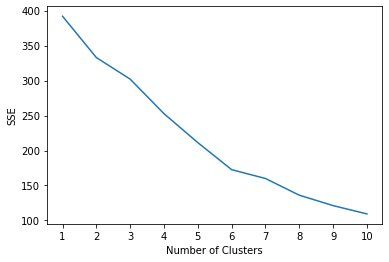

In [20]:
#  plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig('../report/assets/cluster-sse-before-pca.svg')
plt.show()

In [21]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [22]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [23]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=3,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [24]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [25]:
pipe.fit(seperated_reason_2019D)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

In [26]:
preprocessed_data = pipe["preprocessor"].transform(seperated_reason_2019D)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.5344205709199814

In [27]:
preprocessed_data

array([[ 4.48778442e-02, -8.52064379e-02],
       [ 2.31541646e-01,  7.98483990e-02],
       [ 8.91588933e-05, -8.43128827e-02],
       [-6.02179912e-02, -9.95601106e-02],
       [-4.32665059e-01, -2.15969592e-01],
       [-7.81112041e-03, -6.86143778e-02],
       [ 4.21407862e-02,  1.17075133e-01],
       [ 1.78778854e-01,  3.45676528e-02],
       [ 6.10799968e-01,  5.13197483e-01],
       [ 4.47157458e-01,  3.00685518e-01],
       [-2.08106646e-01, -4.98379726e-01],
       [-2.90067844e-01,  2.27304757e-01],
       [ 2.85701713e-01, -5.04552544e-02],
       [-2.99291170e-01,  8.07038428e-02],
       [ 1.52694392e-02, -2.70007352e-01],
       [ 7.72105593e-02, -2.11640879e-01],
       [ 4.23483109e-02, -1.88975428e-01],
       [-6.31113972e-01,  6.75186729e-01],
       [-3.89318112e-01, -4.42306514e-01],
       [ 1.35336473e-01, -1.14976914e-01],
       [-2.83572947e-01,  4.40893720e-02],
       [-5.50633554e-02, -2.25724870e-01],
       [-1.69552015e-01, -2.15728063e-02],
       [ 2.

In [28]:
predicted_labels

array([0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0], dtype=int32)

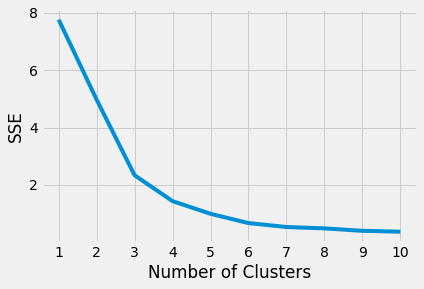

In [29]:
# now plot the preprocessed_data sse

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_data)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig('../report/assets/cluster-sse-after-pca.svg')
plt.show()

In [30]:
len(predicted_labels)

49

In [31]:
seperated_reason_2019D['Cluster'] = predicted_labels

In [32]:
seperated_reason_2019D

,Completed,Dropped-out,Terminated,Transferred,Incarcerated,Death,Other,Case_Count,Cluster
STFIPS,,,,,,,,,
1.0,0.339134,0.347795,0.079310,0.131195,0.021010,0.002085,0.079471,12470,0
2.0,0.383464,0.180599,0.191406,0.119531,0.022135,0.003125,0.099740,7680,2
4.0,0.993181,0.000540,0.000150,0.000285,0.005050,0.000517,0.000277,133455,0
5.0,0.592885,0.203557,0.069582,0.123106,0.010128,0.000412,0.000329,12144,0
6.0,0.231985,0.489734,0.000301,0.262169,0.012457,0.002962,0.000391,133017,0
8.0,0.752824,0.111712,0.036575,0.078246,0.009254,0.000828,0.010560,54354,0
9.0,0.429340,0.203299,0.037332,0.198799,0.015119,0.003043,0.113069,62440,0
10.0,0.370138,0.136870,0.296398,0.139358,0.026719,0.005370,0.025147,7635,0
11.0,0.514259,0.002760,0.055198,0.094526,0.004600,0.003680,0.324977,4348,2


In [33]:
# Census_state = 
state_stfps = pd.read_csv("lib/Census state FIPS code.txt", sep=" ", header=0, names = ['STFIPS', 'State', 'Frequency', 'Percentage'], index_col=0)


In [34]:
# seperated_reason_2019D.merge(state_stfps)
clustereda_state = pd.merge(seperated_reason_2019D, state_stfps, left_index=True, right_index=True)

In [35]:
# clustereda_state.to_csv("clustered_state.csv")

In [36]:
clustereda_state[clustereda_state['Cluster']==2]

,Completed,Dropped-out,Terminated,Transferred,Incarcerated,Death,Other,Case_Count,Cluster,State,Frequency,Percentage
STFIPS,,,,,,,,,,,,
2.0,0.383464,0.180599,0.191406,0.119531,0.022135,0.003125,0.099740,7680,2,Alaska,"7,680",0.4%
11.0,0.514259,0.002760,0.055198,0.094526,0.004600,0.003680,0.324977,4348,2,District_Columbia,"4,348",0.3%
12.0,0.449077,0.159668,0.019329,0.079551,0.011931,0.001100,0.279344,30006,2,Florida,"30,006",1.7%
16.0,0.382303,0.270342,0.000000,0.164051,0.078729,0.002374,0.102202,7583,2,Idaho,"7,583",0.4%
33.0,0.385932,0.111027,0.085551,0.155513,0.028897,0.001141,0.231939,2630,2,NewHampshire,"2,630",0.2%
38.0,0.254545,0.305455,0.025455,0.138182,0.010909,0.029091,0.236364,275,2,NorthDakota,275,0.0%
42.0,0.381938,0.220513,0.058484,0.047700,0.035030,0.001772,0.254563,26520,2,Pennsylvania,"26,520",1.5%
51.0,0.349583,0.000754,0.371034,0.000754,0.041016,0.003489,0.233369,21211,2,Virginia,"21,211",1.2%
56.0,0.438444,0.196671,0.034069,0.120015,0.045103,0.003291,0.162408,5166,2,Wyoming,"5,166",0.3%


In [37]:
clustereda_state[clustereda_state['Cluster']==0].State.index

Index([ 1.0,  4.0,  5.0,  6.0,  8.0,  9.0, 10.0, 13.0, 15.0, 17.0, 18.0, 19.0,
       20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0,
       34.0, 36.0, 39.0, 40.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 55.0,
       72.0],
      dtype='object', name='STFIPS')

In [38]:
len(clustereda_state[clustereda_state['Cluster']==0].State.index)

37

In [39]:
cluster_PCA  = pd.DataFrame(preprocessed_data, columns = ['PCA1','PCA2'], index = seperated_reason_2019D.index)

In [40]:
cluster_PCA = pd.merge(cluster_PCA, state_stfps, left_index=True, right_index=True)

In [41]:
cluster_PCA['Cluster'] = predicted_labels

In [42]:
chart = alt.Chart(cluster_PCA).mark_circle(size=50).encode(
    x='PCA1',
    y='PCA2',
    color='Cluster:N',
    tooltip=['State', 'Frequency', 'Percentage']
).interactive()

chart.save('../report/assets/pca-cluster.html')

chart

alt.Chart(...)

In [43]:
end_time = datetime.datetime.now()
end_time

datetime.datetime(2022, 4, 25, 3, 30, 55, 212435)

In [44]:
# How long it took to run our entire notebook
end_time - start_time

datetime.timedelta(seconds=12, microseconds=814853)